# ELOPE: Starter Notebook

This notebook contains code to get you started working with the data that is coming with the [ELOPE](https://kelvins.esa.int/elope/) challenge on ESA's [Kelvins](https://kelvins.esa.int) platform.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

# 1. Opening the data

In [2]:
# specify path to dataset
datapath = './data'

### Dataset Folder Structure

The dataset is organized into two main folders: **train** and **test**. Each folder contains multiple `.npz` files, which correspond to what we call a **landing sequence** or **sequence** for short.

Each file (e.g., `0000.npz`, `0001.npz`, etc.) encapsulates the following data:
- **events**: synethtic event data.
- **traj**: trajectory information (state of the lander).
- **timestamps**: time stamps corresponding to the trajectory information.
- **range_meter**: range meter information.

We inspect `0000.npz` as an example here:

In [3]:
fn = os.path.join(datapath, 'train', '0000.npz')
sequence = np.load(fn)

In [4]:
print(sequence.keys())

KeysView(NpzFile './data/train/0000.npz' with keys: events, timestamps, traj, range_meter)


## 1.1 Opening and visualizing event data

Events are stored as 1-dimensional numpy arrays. Each element encodes an event as a 4-tuple `(x, y, p, t)`:
* **x**: x coordinate of event
* **y**: y coordinate of event
* **p**: polarity of event:
   * *True* for positive polarity
   * *False* for negative polarity
* **t**: timestamp of event in µs

In [5]:
events = sequence['events']
print("5 examples of events:")
for i in range(15465,15470):
    print(events[i])

5 examples of events:
(18, 6, False, 265000)
(76, 189, True, 265000)
(111, 51, False, 265000)
(94, 184, True, 265000)
(67, 42, True, 265000)


For convenience, we will use the `pandas` library to work with a dataframe instead of this representation for the remainder of this notebook.

In [6]:
ev_data = pd.DataFrame(events, columns=['x','y','p','t'])

In [7]:
print(ev_data)

           x    y      p         t
0        191   47   True     12000
1         67   46   True     13000
2         34   34   True     14000
3        182   37   True     14000
4        188   60  False     14000
...      ...  ...    ...       ...
6303273   55   31   True  47362000
6303274  135  138  False  47362000
6303275   11   51   True  47362000
6303276   28   55  False  47362000
6303277  196   77   True  47362000

[6303278 rows x 4 columns]


There are multiple ways on how to visualize event data. In the following, we will plot all events that happen between timepoints 0.2 and 0.3 in an **x-y-t**-plot.

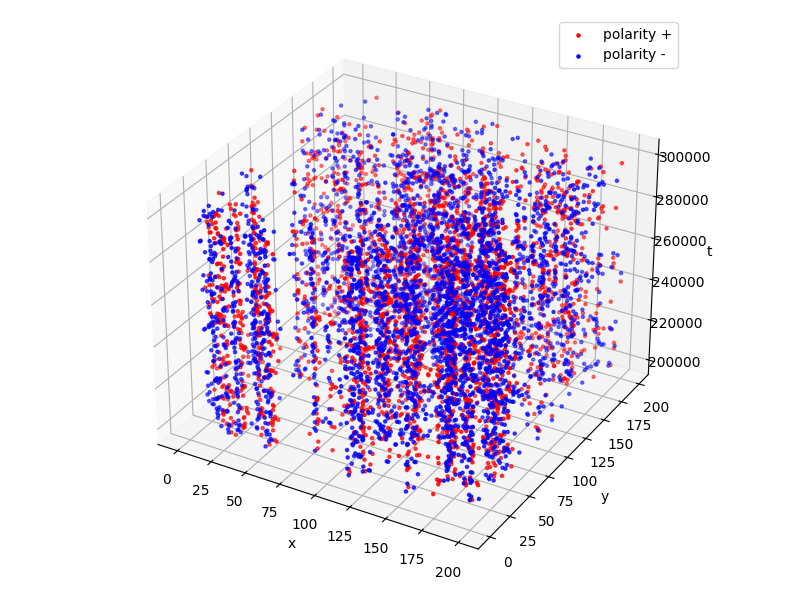

In [8]:
# filter for positive polarity events and time [0.2, 0.3] seconds
pos_ev = ev_data.loc[(ev_data['p'] == True) & ev_data['t'].between(200000,300000), ['x','y','t']]

# filter for negative polarity events and time [0.2, 0.3] seconds
neg_ev = ev_data.loc[(ev_data['p'] == False) & ev_data['t'].between(200000,300000), ['x','y','t']]

# plot in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# plot the points with p == True in red and p == False in blue
ax.scatter(pos_ev['x'], pos_ev['y'], pos_ev['t'], c='red', label='polarity +', s=5)
ax.scatter(neg_ev['x'], neg_ev['y'], neg_ev['t'], c='blue', label='polarity -', s=5)

# set axis labels and limits
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')

plt.legend()
plt.tight_layout()
plt.show()

The **x-y-t**-plot is a truthful visualization that does not omit any information. However, it is often too cluttered to be helpful. A different visualization is the **event-frame**, which is reminiscent of frame-based RGB cameras. In this visualization, a slice of time (for example 1 second) is flattened into a 2D **x-y**-plot.

In [9]:
def event_frame(ev_data, start_t, acc_t = 1e5):
    """ Takes pandas dataframe ev_data [x,y,p,t] and generates event-frame by
        slicing beginning from start_t for a duration of acc_t """
    assert acc_t >= 0
    assert start_t >= 0
    
    # slice event dataframe
    ev_slice = ev_data.loc[ev_data['t'].between(start_t,start_t + acc_t)]

    # determine latest events (previous events of the slice will be ignored in this representation)
    max_entries = ev_slice.loc[ev_slice.groupby(['x', 'y'])['t'].idxmax()]
    pos_ev = max_entries.loc[(max_entries['p'] == True), ['x','y']]
    neg_ev = max_entries.loc[(max_entries['p'] == False), ['x','y']]

    # create empty event frame
    ev_frame = np.zeros([200,200,3], dtype=np.uint8)

    # to be easy on the eye, we will use a blueish color for negative polarity and white for positive polarity
    ev_frame[pos_ev['x'], pos_ev['y']] = [255, 255, 255]
    ev_frame[neg_ev['x'], neg_ev['y']] = [80, 137, 204]

    return ev_frame

Text(0.5, 1.0, 'event frame [200000, 300000] (acc. time: 100000)')

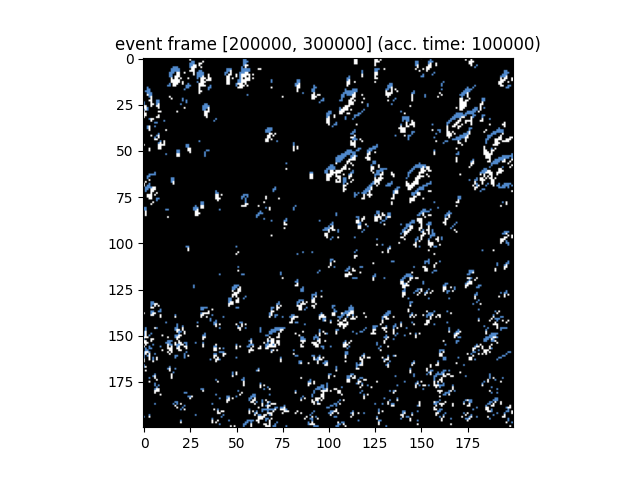

In [10]:
fig, ax = plt.subplots()
start_t, end_t = 200000, 300000
ev_frame = event_frame(ev_data, start_t, end_t - start_t)
# we need to swap the axis so that `imshow` shows coordinates as one would expect
_ = ax.imshow(np.swapaxes(ev_frame, 0, 1))
ax.set_title(f'event frame [{start_t}, {end_t}] (acc. time: {end_t - start_t})')

If you have `ipywidgets` installed, you can step through the event slices with the following code:

interactive(children=(FloatSlider(value=23681000.0, description='start_t', max=47362000.0, step=473620.0), Flo…

<function __main__.update_event_frame_plot(start_t, acc_t)>

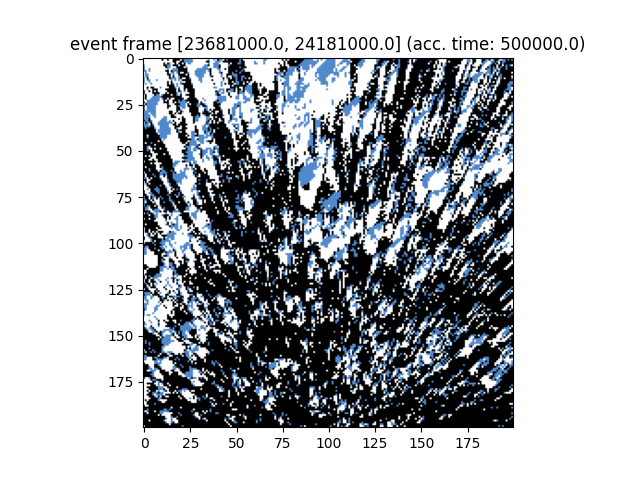

In [11]:
from ipywidgets import interact

fig, ax = plt.subplots()
ev_frame = event_frame(ev_data, 200000, 100000)
image = ax.imshow(np.swapaxes(ev_frame, 0, 1))

max_T = max(ev_data['t'])

def update_event_frame_plot(start_t, acc_t):
    ev_frame = event_frame(ev_data, start_t, acc_t)
    image.set_data(np.swapaxes(ev_frame, 0, 1))
    ax.set_title(f'event frame [{start_t}, {start_t+acc_t}] (acc. time: {acc_t})')

interact(update_event_frame_plot, start_t = (0, max_T, max_T / 100), acc_t = (0, 1e6, 1e4))

## 1.2 Opening and visualizing trajectory data

The trajectories of the lander are stored as 2-dimensional numpy arrays. Each row corresponds to a **timestamp** (also given as a separate numpy array) and represents what is known about the **state vector** at that time. The state vector is a 12-tuple `(x, y, z, vx, vy, vz, phi, theta, psi, p, q, r)` describing
* **x,y,z**: position in global frame (the attitude z is given negative by convention) [m]
* **vx, vy, vz**: velocity vector [m/s]
* **phi, theta, psi**: roll, pitch, jaw Euler angles [rad]
* **p, q, r**: spacecraft (hence camera) angular velocity [rad/s]

The position and velocity components are masked out with `np.nan` for each trajectory from the **test** folder. It is your task to recover the velocity from the event-stream and the rest of the provided data.

Every trajectory is sampled at 120 points in time, which are found in the **timestamp** array. While every trajectoy has the same amount of timestamps, the timestamps themselves differ between trajectories.

We inspect `0000.npz` again as an example:

In [12]:
t = sequence['timestamps'] 
x = sequence['traj']

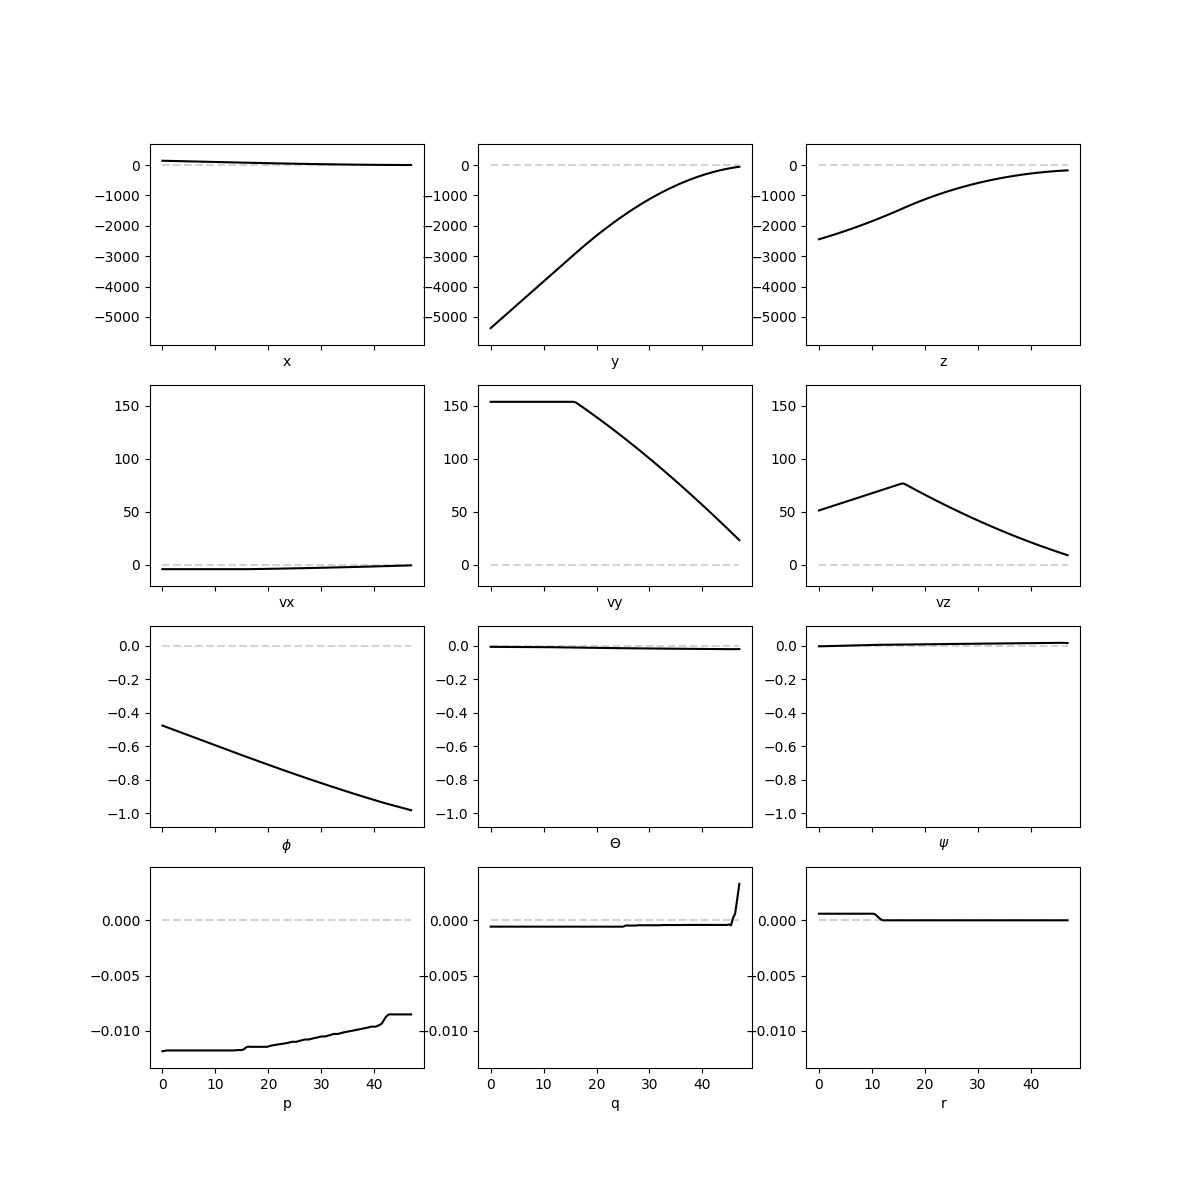

In [13]:
nrows, ncols = 4, 3
labels = [['x','y','z'],
          ['vx','vy','vz'],
          ['$\\phi$','$\\Theta$','$\\psi$'],
          ['p','q','r']]

# Find the minimum and maximum y-values across each row
y_mins, y_maxs = [], []
for row in range(nrows):
    row_data = x.T[row * ncols: (row + 1) * ncols]
    y_mins.append(np.min(row_data))
    y_maxs.append(np.max(row_data))
    
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12), sharex='col')

# Set y-limits for each row
for row_id in range(nrows):
    for col_id in range(ncols):
        # index in state vector
        idx = row_id * ncols + col_id
        if idx > 12:
            axes[row_id, col_id].remove()
            continue
        
        # plotting
        axes[row_id, col_id].plot([t[0], t[-1]], [0,0], color='lightgrey', linestyle='--')
        axes[row_id, col_id].plot(t, x.T[idx], 'k-')

        # padding
        h = (y_maxs[row_id] - y_mins[row_id]) / 10
        axes[row_id, col_id].set_ylim(y_mins[row_id] - h, y_maxs[row_id] + h)
        axes[row_id, col_id].set_xlabel(labels[row_id][col_id])

## 1.3 Opening and visualizing rangemeter

Lastly, the sequence contains **rangemeter** information, which is presented as another 2-dimensional numpy-array. The rangemeter measures the distance from the center of the camera to the surface point which corresponds to the position (100, 100) in the camera field of view. In a purely ventral landing with the lander descending the surface normal, the value of the range-meter would be identical to the altitude of the lander. But since our lander maneuvers during its descent, this is not the case for this data. The following visualization shows the rangemeter data against the trajectory $z$ - coordinate (as a proxy for the altitude).

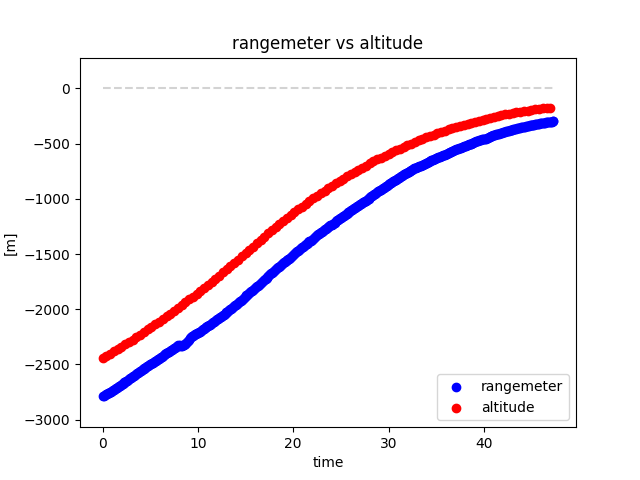

In [26]:
rm = sequence['range_meter']
x = sequence['traj']

fig, ax = plt.subplots()
rmax = np.max(rm[:,1])

ax.scatter(rm[:,0], -rm[:,1], color='blue', label='rangemeter')
ax.scatter(t, x[:,2], color='red', label='altitude')
ax.plot([rm[:,0][0], rm[:,0][-1]], [0,0], color='lightgrey', linestyle='--')

ax.set_ylim(-rmax - (rmax / 10), 0 + rmax / 10)
ax.set_xlabel('time')
ax.set_ylabel('[m]')
ax.set_title('rangemeter vs altitude')
ax.legend(['rangemeter','altitude'])

While the rangemeter covers the whole duration of each trajectory, it is sampled at a constant rate of 10Hz. Consequently, the rangemeter comes with **it's own timestamps** that are saved in the first column of its numpy array. The second column gives the actual distance.

# 2. Making a submission

The goal of the competition is to reconstruct the **velocity** of **all** sequences in the **test** part of the data. We will use `0028.npz` as an example to show that this information has been masked out from the trajectory part:

In [ ]:
fn = os.path.join(datapath, 'test', '0028.npz')
sequence = np.load(fn)

In [ ]:
# no velocities (showing only first 5 entries)
print(sequence['traj'][:5,3:6])

A submission is a textfile in .JSON format, that contains an object of velocity components for each sequence of the test set. For each sequence, the velocity needs to be sampled at every timestamp accordingly. Thus, the structure of the .JSON-file should look like this:
```
{
  "28": {
    "vx": [ ... ],
    "vy": [ ... ],
    "vz": [ ... ]
          },
  "49": {
    "vx": [ ... ],
    "vy": [ ... ],
    "vz": [ ... ]
          },

  ...

  "92": {
    "vx": [ ... ],
    "vy": [ ... ],
    "vz": [ ... ]
          },
}

We recommend to stick to this schema as close as possible, as our validation is rather **strict**. For example, it will fail should you
* omit a sequence from test
* list a duplicate sequence
* have more sequences than the ones in test
* have invalid or missing values in any of the velocity arrays
* omit any of the three velocity components
* add redundant key-value pairs anywhere
* have too little or too many values in the velocity arrays
* etc.

In the following, we generate a bogus-submission containing random numbers but adhering to the correct format:

In [ ]:
bogus = dict()
for sequence_id in range(28, 93):
    vx = np.random.uniform(-10000, 10000, size=(120,))
    vy = np.random.uniform(-10000, 10000, size=(120,))
    vz = np.random.uniform(-10000, 10000, size=(120,))

    bogus[sequence_id] = {"vx": vx.tolist(), "vy": vy.tolist(), "vz": vz.tolist()}

In [ ]:
# writing submission-file to drive
import json
with open('bogus_submission.json', 'wt') as f:
    json.dump(bogus, f)